# はじめに
[前回に]()続いて、Kaggleのタイタニック号沈没事故生存者予想を行います。

今回試行錯誤の結果、最高正解率80%で、上位13%の成績が出ました。(1321位/10681グループ中)  
ただ、正直言えば偶然よくなったというパターンで、もう少しカーネルを見ながら研究する必要があるように思えます。

以下使用したコードの詳細の説明となります。



# 使用する特徴量

## 欠損値の問題


船室(Cabin)のデータと、客室の等級(Pclass)のデータは、生存と死亡の重要な特徴量になります。  
タイタニック号の客室は船首・船尾で区別されるのではなく、一等客室ほど高い位置にあり救命ボートにもアクセスしやすかったからと言われています。
ただ客室のデータに関しては、Kaggleの訓練データの80%が欠損しているということもあって、前回は使用せずにいました。    
今回、他のKaggle参加者のカーネルを読んでいると、このデータを通常の特徴量として使用している方と、無意味と考えて使用しない方針の方がいたので、今回は試しに船室のデータの頭文字を数字に置き換えて使用することにします。

In [ ]:
## 船室の欠損値はゼロを代入
train_test['Cabin'] = train_test['Cabin'].fillna(0)
## 頭文字だけ抽出
train_test['Cabin'] = train_test['Cabin'].apply(lambda x: str(x)[0])
train_test['Cabin']=train_test['Cabin'].replace("A",1).replace("B",2).replace("C",1).replace("0",0).replace("D",2).replace("E",2).replace("F",1).replace("G",1) 
train_test['Cabin']=train_test['Cabin'].replace("T",0)


また切符(Ticket)の文字数と、その頭文字を特徴量として使用することにしました。  
頭文字の方は生存と相関したのですが、切符文字数はあまり意味がなかったように思えます。

また配偶者とキョウダイの数(SibSp)や、親と子供の数(Parch)は、予測に貢献していると思えないというのが本音ですが
いくつかのカーネルを読む限り、同乗者がいたかどうかを名字とチケットと乗車賃で判断している人がいました

ただ今回は試しということで使用してみることにします。


In [ ]:
# チケットの文字数の長さ
train_test['Ticket_Len'] = train_test['Ticket'].apply(lambda x: len(x))
# チケットの頭文字を抽出
train_test['Ticket'] = train_test['Ticket'].apply(lambda x: str(x)[0])

train_test.loc[train_test['Ticket'].isin(['W','F', '4', '7', '6', 'L', '5', '8', '9']),'Ticket'] = 0
train_test['Ticket']=train_test['Ticket'].replace("1",1).replace("2",2).replace("3",3).replace("0",0).replace("S",3).replace("P",0).replace("C",3).replace("A",3) 


## それ以外の欠損値について
等級を意味するPclassなどは、前回同様、その等級の中央値を代入し、  
乗船港は最頻値を代入しています。

データのおよそ20%が欠落している年齢についてですが、前回は多重代入法といった方法で欠損値の補完をしました。  
ただあまり改善しなかったというのが本音で、今回はかなりシンプルに、単純な平均値を代入することにします。


## キョウダイ・配偶者、親・子供の数について
データセットにはキョウダイ(兄弟姉妹)と配偶者を意味するSibSpと、親と子を意味するParchの値があります。  
この数字から、その人物が「**家族関係者を伴わずに一人で乗船したか** 」を大雑把に調べることができます。  

他のカーネルを読んでいると、結構多くの人が「家族と来ていない(IsAlone)」を特徴量として選択していたので、  
今回は"FamilySize"(家族の数)と"IsAlone"(一人である)という２つを新たに使用してみることにします。  

ただこの場合、**友人と来ている** 人物については調べておらず、本当の意味で"IsAlone"ではないかもしれないのと、  
データに記載された家族の数が誤っている場合があり、どうも正確ではないという問題点もあります[^2][^3]。


[^2]: 実際の所、まったく同じ名字で同じ船室に泊まる人物がいるのに、SibSpやParchに記載がない場合もありました。  
今回は省略しますが、次回は名字とチケットを元にして、家族・友人関係まで特徴に含めて分析したいと思います。
[^3]: [Blood is thicker than water & friendship forever](https://www.kaggle.com/shunjiangxu/blood-is-thicker-than-water-friendship-forever)



# デートセットのまとめ

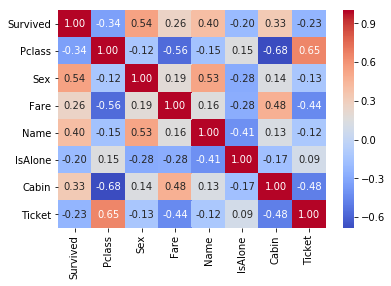

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys

# データの読み込み
train = pd.read_csv("train.csv", dtype={"Age": np.float32}, )
test  = pd.read_csv("test.csv", dtype={"Age": np.float32}, )


# 前処理
## 訓練用データとテスト用データを結合します
train_test  = pd.concat([train,test],sort=False, ignore_index=True)


## 欠損値の補正
## Embarked の欠損値の補完
train_test.Embarked = train_test.Embarked.fillna("S")
train_test.Embarked =train_test.Embarked.replace({"S":0,"C":1,"Q":2})
## 検証用データのFare が欠損値を中央値で補完
train_test.Fare = train_test.Fare.fillna(test.query("Pclass==3").Fare.median())


# チケットの文字数の長さ
train_test['Ticket_Len'] = train_test['Ticket'].apply(lambda x: len(x))
# チケットの頭文字を抽出して代入
train_test['Ticket'] = train_test['Ticket'].apply(lambda x: str(x)[0])

train_test.loc[train_test['Ticket'].isin(['W','F', '4', '7', '6', 'L', '5', '8', '9']),'Ticket'] = 0
train_test['Ticket']=train_test['Ticket'].replace("1",1).replace("2",2).replace("3",3).replace("0",0).replace("S",3).replace("P",0).replace("C",3).replace("A",3) 



## 家族の大きさを計算する
train_test["FamilySize"] = train_test["SibSp"] + train_test["Parch"] + 1

# 一人かどうか判定
train_test['IsAlone'] = 0
train_test.loc[train_test['FamilySize'] == 1, 'IsAlone'] = 1
 
## 船室の欠損値はゼロを代入
train_test['Cabin'] = train_test['Cabin'].fillna(0)
## 頭文字だけ抽出
train_test['Cabin'] = train_test['Cabin'].apply(lambda x: str(x)[0])
train_test['Cabin']=train_test['Cabin'].replace("A",1).replace("B",2).replace("C",1).replace("0",0).replace("D",2).replace("E",2).replace("F",1).replace("G",1) 
train_test['Cabin']=train_test['Cabin'].replace("T",0)


#性別を埋める
train_test.Sex =train_test.Sex.replace('male', 0)
train_test.Sex =train_test.Sex.replace('female', 1)

#名前を敬称で埋める
## 少数の敬称はすべてRareに一度置き換え
train_test.Name =train_test.Name.str.replace('Lady|Countess|Capt|Col|Don|Dr|Major|Rev|Sir|Jonkheer|Dona', 'Rare', regex=True)
train_test.Name =train_test.Name.str.replace('Mlle', 'Miss')
train_test.Name =train_test.Name.str.replace('Ms', 'Miss')
train_test.Name =train_test.Name.str.replace('Mme', 'Mrs')


# 名前を敬称のダミー変数で埋める
for i in range(len(train_test)):
    if "Mrs" in str(train_test['Name'][i]):
        train_test.loc[i,'Name'] = 3
    elif "Miss" in str(train_test['Name'][i]):
        train_test.loc[i,'Name'] = 2
    elif "Mr" in str(train_test['Name'][i]):
        train_test.loc[i,'Name'] = 1
    elif "Master" in str(train_test['Name'][i]):
        train_test.loc[i,'Name'] = 4
    elif "Rare" in str(train_test['Name'][i]):
        train_test.loc[i,'Name'] = 5
train_test.Name.fillna(0) 

# 以前はこの段階でダミー変数に変換があったのですが、今回はただコピーするだけ
train_test_dummies = train_test.copy()

## 年齢の補完
# 平均による補完
train_test_dummies["Age"].fillna(train_test.Age.mean(), inplace=True) 
train_test_dummies["Fare"].fillna(train.Fare.mean(), inplace=True)



## 訓練データと評価データに分離
train_dummies = train_test_dummies[train_test_dummies.PassengerId < 892]
test_dummies = train_test_dummies[train_test_dummies.PassengerId >= 892]

p_id = test_dummies['PassengerId']# あとで予測用に使用するためp_idに保存する
del test_dummies['PassengerId']
del test_dummies['Survived']
del train_dummies['PassengerId']

## ラベルデータだけ抜き出してから削除し、残りを学習用データにする
y = train_dummies.loc[:, ["Survived"]]#Pclass以降の変数
del train_dummies['Survived']
x = train_dummies
x.describe()

## 相関行列のヒートマップ
g = sns.heatmap(train_test_dummies[["Survived","Pclass","Sex","Fare","Name",'IsAlone','Cabin','Ticket',]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")



# 今回のデータの問題点
実は今回使用したデータセットですが、このタイミングで誤って意味のない処理を加えています。  
訓練用データの一部を、テスト用データに代入してしまっています。  
普通なら正解率が低下するはずなのですが、結局この誤った設定で最高値を出してしまいました。  
本当ならこの処理なしで最高値を出したかったのですが、残念ながらこれ以上の成績がとれなかったということで残しておきます。  

In [15]:
# FamilySizeの代入
test_dummies.reset_index(drop=True,inplace=True)
test_dummies.loc[:,"FamilySize"]=0
test_dummies.loc[:,"FamilySize"] = x["SibSp"] + x["Parch"] + 1

test_dummies.loc[:,'IsAlone'] = 0
test_dummies.loc[test_dummies['FamilySize'] == 1, 'IsAlone'] = 1

# グリッドサーチ
ハイパーパラメータの設定のため、前回同様グリッドサーチを使用します。  
今回はランダムフォレストをアルゴリズムとして使用します。


In [ ]:
# グリッドサーチ
from sklearn.model_selection import GridSearchCV

# ランダムフォレスト
from sklearn.ensemble import RandomForestClassifier

# 学習用データとテスト用に分離
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2,train_size=0.8,shuffle=True) 

# 設定するハイパーパラメータ
param = [
    {"max_depth":[20,25,30,35],
     "min_samples_leaf":[1,4,7],
     'max_features': [1, 'auto', None],
     "min_samples_split":[5,10,15],
     "n_estimators":[40,50,70],
     'max_depth': [1, 5, 10, None],
     "n_jobs":[3,5,8],
     "bootstrap":(True,False),
    }
]

# クロスバリデーション用モジュールを読み込む
from sklearn.model_selection import KFold, cross_val_score

# 正解率の計算用
from sklearn.metrics import accuracy_score

K_FOLD_NUM=20
kfold_cv = KFold(n_splits=K_FOLD_NUM, shuffle=True)

clf = GridSearchCV(RandomForestClassifier(),param, cv=kfold_cv,verbose=3)
clf.fit(x_train,y_train.values.ravel())
print("最適なパラメータ : ",clf.best_estimator_)
print("最適なスコア : " ,clf.best_score_)  
# 最適なパラメータの評価
y_pred=clf.predict(x_test)
print("最適な予測正解率 : ",accuracy_score(y_test,y_pred))


# 実際に予測する
最適なパラメータについて結果は出ましたが、一つだけでは心もとないので、途中経過で表示されたいくつかの最適なパラメータ候補を実装してみることにしました。  
これには実際にKaggleに投稿しながら、最適なものを見つけるというやや強引な方法を取りましたが、    

もっとも成績がよかったものだけ、以下にコードでした。




In [16]:

from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=7, min_samples_split=15, 
            min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=5,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

clf.fit(x, y.values.ravel())
Y_pred = clf.predict(test_dummies)

# 正解率の計算用
from sklearn.metrics import accuracy_score


import csv
with open("Predict_result_data.csv", "w") as f:
    writer = csv.writer(f, lineterminator='\n')
    writer.writerow(["PassengerId", "Survived"])
    for pid, survived in zip(p_id, Y_pred.astype(int)):
        writer.writerow([pid, survived])
print("done")

done


# 終わりに

今回はランダムフォレストを利用しましたが、実はこれ以外にも様々な手法で試していました。  
ここには書いていませんが、様々な方法で試した結果、かろうじて偶然の産物によって80%を超えることができたので、あまり成功した例とはいえません。


ただカーネルを読んで他人の例を学んだ方が良いように思えるので、次回からはそれらを参考にしてデータを構成してみます。

# 参考

- [Titanic [0.82] - [0.83] ](https://www.kaggle.com/konstantinmasich/titanic-0-82-0-83)
- [Blood is thicker than water & friendship forever](https://www.kaggle.com/shunjiangxu/blood-is-thicker-than-water-friendship-forever)
- クジラ飛行机『PythonによるAI・機械学習・深層学習アプリのつくり方』
